# End-to-End Machine Learning Project: Housing Price Prediction

This notebook walks through a complete **end-to-end machine learning project**, following industry best practices.

---

## Project Checklist

We follow a standard machine learning workflow:

1. Frame the problem and understand the big picture  
2. Get the data  
3. Explore the data to gain insights  
4. Prepare the data for machine learning algorithms  
5. Train and evaluate multiple models  
6. Fine-tune the best models  
7. Present the final solution  
8. Deploy, monitor, and maintain the system  




## 1. Big Picture Overview

The objective is to build a model that predicts **median housing prices** for districts in California using census data.  
Each district (block group) includes features such as population, median income, and housing-related statistics.

The model should learn meaningful patterns from historical data and generalize well to new, unseen districts.

---

### Framing the Problem

Before building any model, it is essential to understand the **business objective**.

- The model’s predictions will be used as an **input to another machine learning system**
- That downstream system determines whether it is worth investing in a given district
- Prediction accuracy directly impacts business revenue

Currently, housing prices are estimated manually by experts using up-to-date information and complex domain-specific rules.  
The goal of this project is to automate and improve this process using machine learning.

---

### Problem Type and Learning Setup

Based on the problem definition:

- **Learning type:** Supervised learning  
- **Task:** Regression  
- **Regression structure:**
  - Multiple regression (multiple input features)
  - Univariate regression (a single target value)
- **Training approach:** Batch learning  
  - The dataset fits in memory  
  - There is no need for frequent or real-time updates  

This framing directly influences the choice of algorithms, evaluation metrics, and system design.

---

### Performance Measure

For this regression task, **Root Mean Square Error (RMSE)** is used as the evaluation metric.

RMSE provides a clear measure of how large prediction errors typically are, while penalizing larger errors more strongly.  
This makes it well-suited for housing price prediction.

---

### Assumptions Check

A critical assumption is that the **actual predicted prices** are required by the downstream system.

If prices were later converted into categories (e.g., *cheap*, *medium*, *expensive*), the problem would instead need to be framed as a classification task.

After confirming with the downstream team that **exact price values are required**, the regression framing is validated.

---

### Conclusion

With the problem clearly framed, assumptions verified, and performance metrics defined, the project is ready to move forward into data acquisition, exploration, and modeling.

This structured approach ensures the solution is:
- Technically sound  
- Aligned with business goals  
- Maintainable and extensible in production  


In [1]:
# Import necessaries libraries 
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

## 2. Get the Data

In [2]:
# Data Acquisition: This step downloads and loads the California housing dataset.
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("../datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("../datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="../datasets")
    return pd.read_csv(Path("../datasets/housing/housing.csv"))

housing_df = load_housing_data()

# make a copy of original datasets
housing = housing_df.copy()

## 3. Explore the DataSets

### I. Data Structure Quick Look

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
len(housing)

20640

In [5]:
# Data info
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
housing.describe(include="object")

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


In [8]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

**Histogram Plot**

In [9]:
# Save useful images
image_path = Path("../images/housing_price_prediction")
image_path.mkdir(parents=True, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = image_path / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [10]:
# Redefine the plot configuration
plt.rcParams.update({
    'font.size':14,
    'axes.labelsize':14,
    'axes.titlesize':14,
    'xtick.labelsize':10,
    'ytick.labelsize':10
})

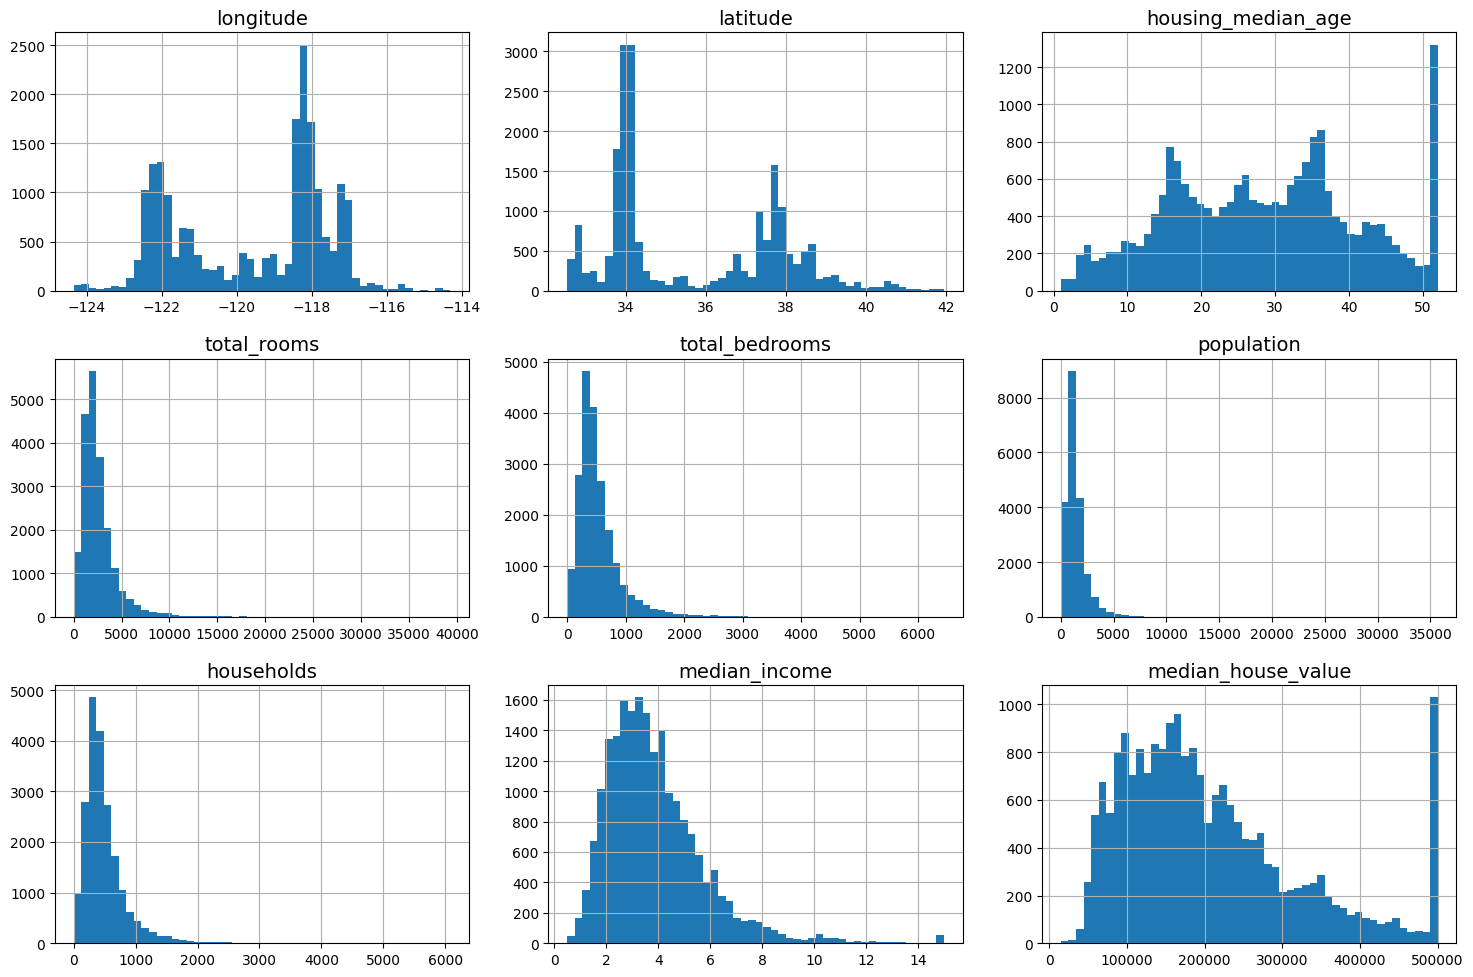

In [11]:
# Histogram plot
housing.hist(bins=50, figsize=(15,10))
save_fig(fig_id="histogram_plots")
plt.show()

### II. Creating Test Set

**Why do we create a test set early?**

We set aside a test set before exploring the data deeply to avoid **data snooping bias**.
If we look at test data too early, we may unintentionally tune our decisions to it, leading to over-optimistic performance estimates.

**The test set should:**
* Represent unseen data
* Stay unchanged throughout the project
* Be used only for final evaluation

**How to create Train Test Set**

Stratified Sampling (Recommended)
* Why stratification: Based on our data, Median income feature influence mostly the target. If an important feature (like median income) strongly influences the target, we must ensure the test set preserves its distribution.


In [12]:
# Stratified Sampling
# step 1: create income categories
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5]) 

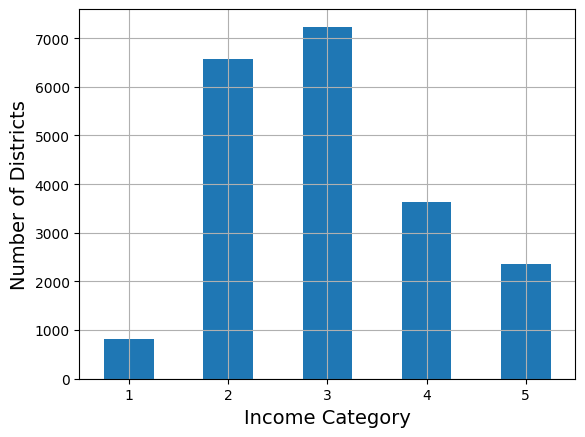

In [13]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.show()

In [14]:
# Step 2: Stratified Train-Test Split
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(
    housing,
    test_size = 0.2,
    stratify = housing["income_cat"],
    random_state = 42
)

In [15]:
# Step 3: Remove temporary column 
for set_ in (housing, strat_train_set,strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### III. Exploratory Data Analysis - EDA

* Put the test set aside and only exploring the train‐ing set. make copy of train set to do experiment on it

In [16]:
housing_train = strat_train_set.copy()

**Visualize Geographical Data**

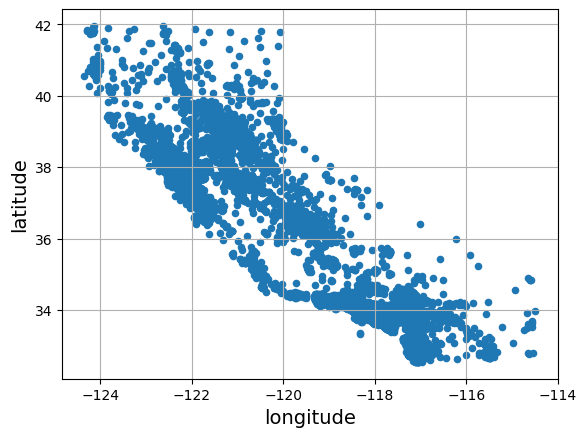

In [17]:
# visualize geographical data using provide geographical information of longitude and latitude
housing_train.plot(kind='scatter', x='longitude', y='latitude', grid=True)
plt.show()

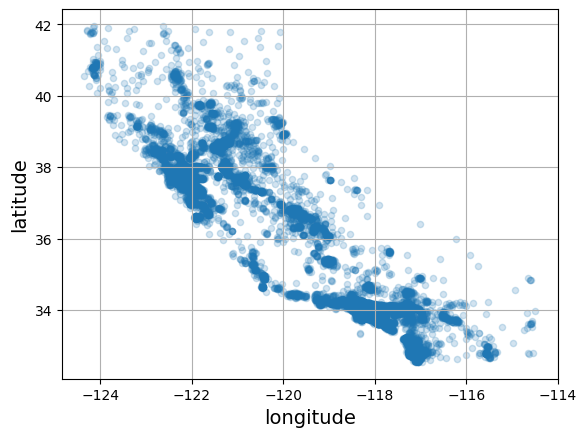

In [18]:
# better visualization of the dense area with
housing_train.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2, grid=True)
plt.show()

Representative visualization of the geographical information with population size and median house value. 
* The radius of each circle represents the district’s population (option s), and the color represents the price (option c).

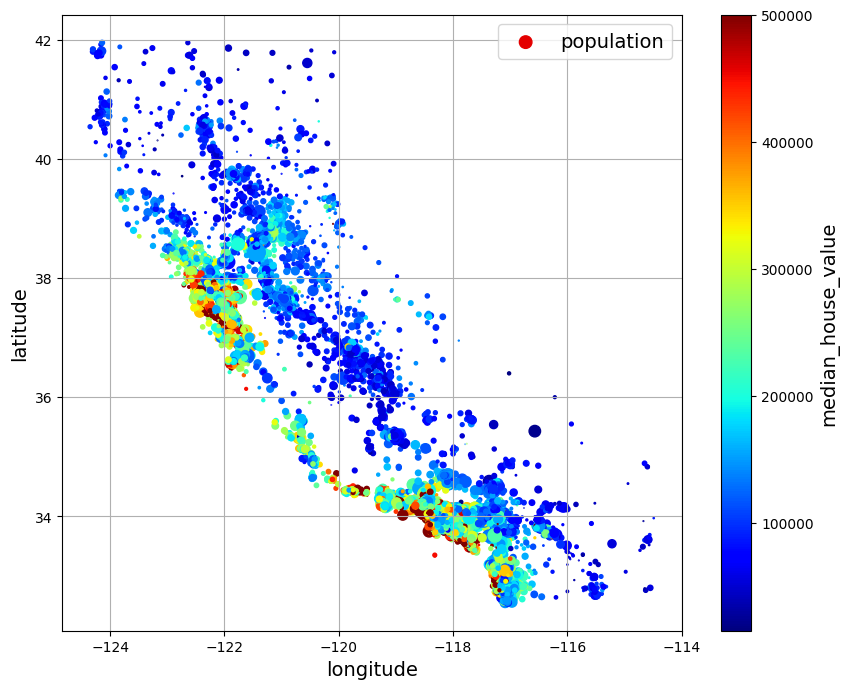

In [19]:
housing_train.plot(kind='scatter', x='longitude', y='latitude', 
                   s=housing_train['population']/100, 
                   c='median_house_value', label='population',
                   cmap='jet', legend=True,
                   grid=True, colorbar=True, figsize=(10,8))
plt.show()

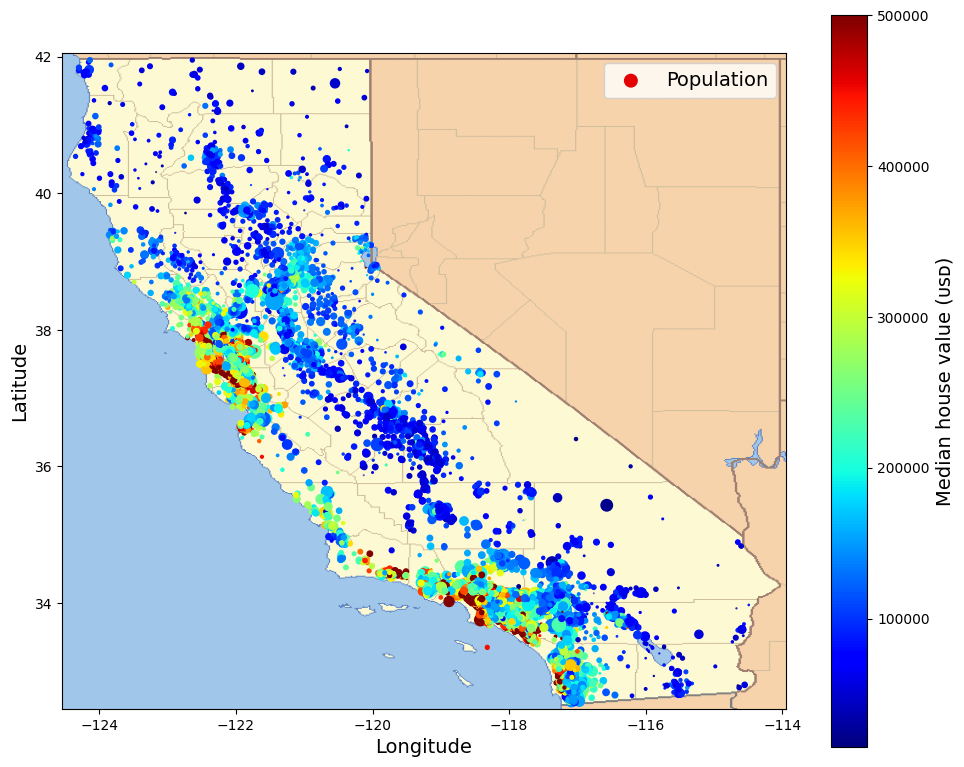

In [20]:
# Draw the geographical information on California Map
filename='california.png'
if not (image_path / filename).is_file():
    url="https://github.com/ageron/handson-ml3/raw/main/images/end_to_end_project/" + filename
    urllib.request.urlretrieve(url, image_path / filename)

housing_renamed = housing_train.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})

housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 8))

california_image=plt.imread(image_path / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_image, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

**Insight**: 
* The area around the beach is more expensive than the other
* Especially around city of Los Angeles, Santa Barbara, San Francisco are more expensive than the other area

**Looking for correlations**

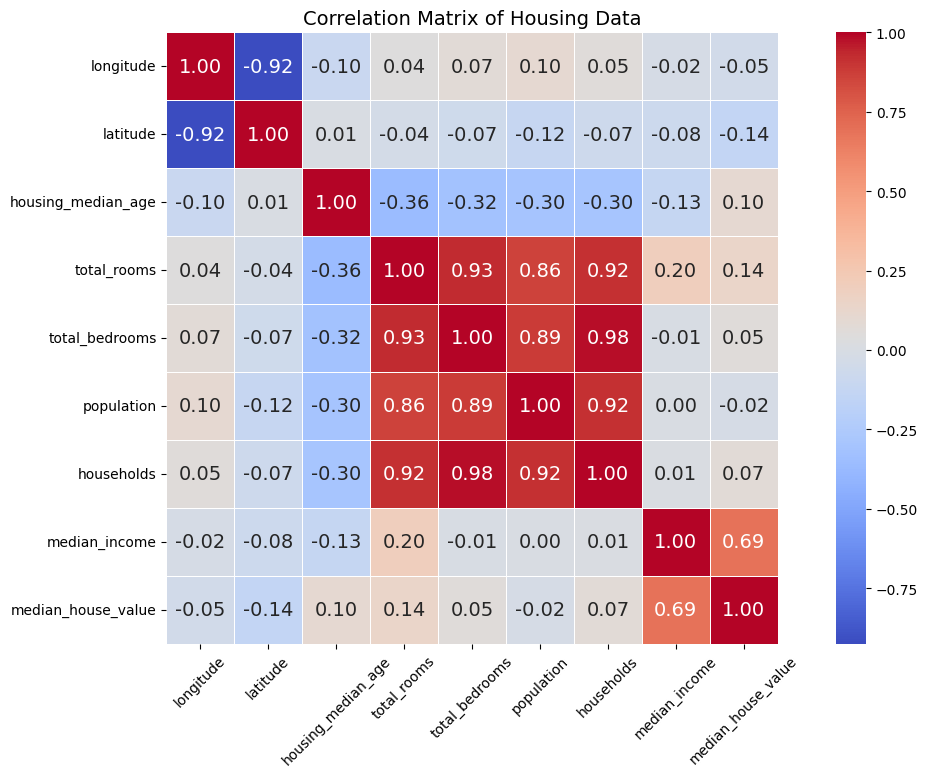

In [21]:
import seaborn as sns
corr_matrix = housing_train.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    linewidths=0.5, 
    cbar=True, 
    square=True
)
plt.title("Correlation Matrix of Housing Data")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
save_fig("correlation_matrix_of_housing_data")
plt.show()


median_income         1.000000
median_house_value    0.688380
total_rooms           0.197720
households            0.013637
population            0.004282
total_bedrooms       -0.006038
longitude            -0.016542
latitude             -0.078137
housing_median_age   -0.127043
Name: median_income, dtype: float64


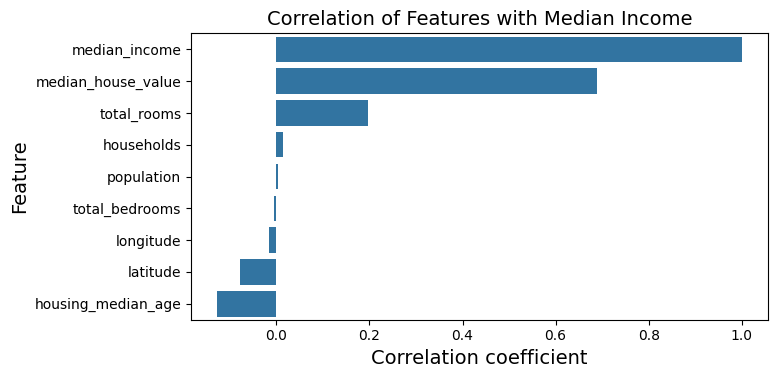

In [22]:
# Housing data correlation with Median Income Value
median_income_corr = corr_matrix["median_income"].sort_values(ascending=False)
print(median_income_corr)
plt.figure(figsize=(8, 4))
sns.barplot(x=median_income_corr.values, y=median_income_corr.index)
plt.title("Correlation of Features with Median Income")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Insight**:
* median house value have strong positive relation with median income
* housing median age have strong negative relation with  median income

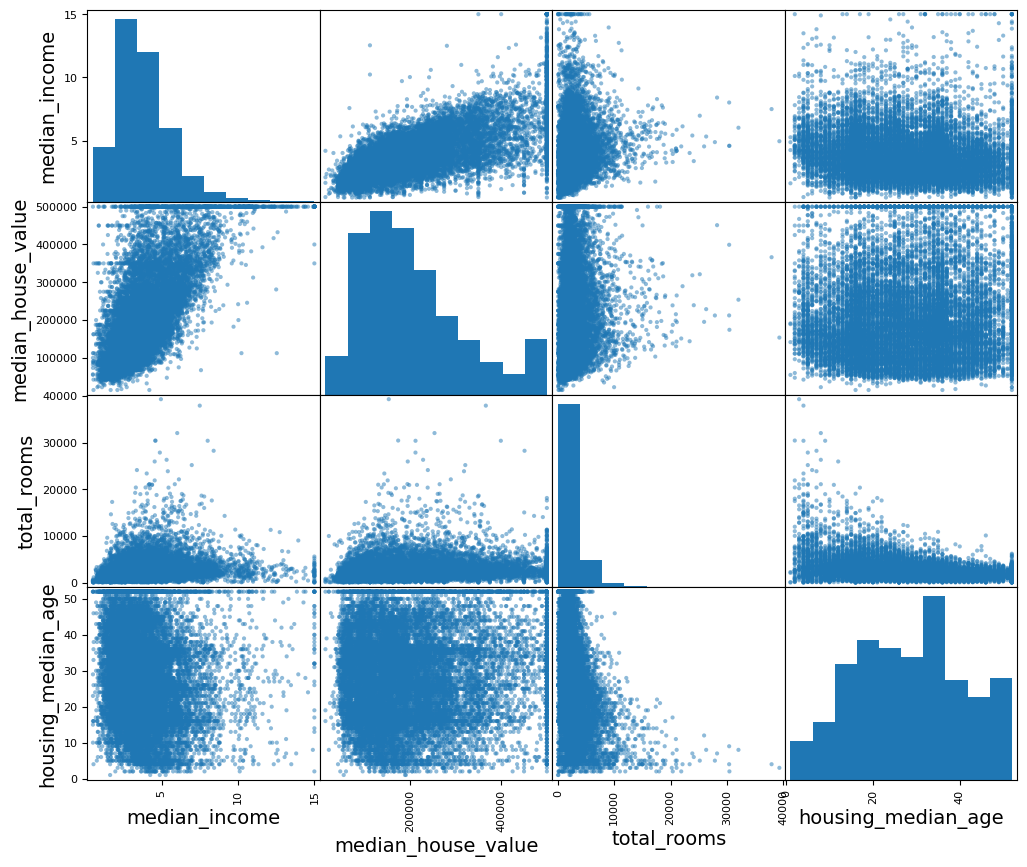

In [23]:
# pandas scatter plot for main attributes
from pandas.plotting import scatter_matrix
attributes = ["median_income", "median_house_value", "total_rooms", "housing_median_age"]
scatter_matrix(housing_train[attributes], figsize=(12,10))
plt.show()

**Insight**:
* We observe linier strong positive relation between median income and median house value

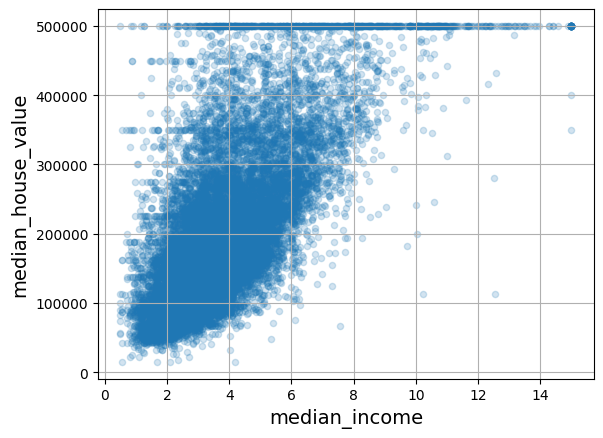

In [24]:
# relation between median income and median house value
housing_train.plot(kind="scatter", x="median_income", y="median_house_value", grid=True, alpha=0.2)
plt.show()

### IV. Feature Engineering

In [25]:
housing_train["rooms_per_house"] = housing_train["total_rooms"] / housing_train["households"]
housing_train["bedrooms_ratio"] = housing_train["total_bedrooms"] / housing_train["total_rooms"]
housing_train["people_per_house"] = housing_train["population"] / housing_train["households"]

In [26]:
corr_matrix = housing_train.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

## 4. Prepare the Data for ML Algorithms

In [28]:
# create a copy of original data and separate the as a train data and label data
housing = strat_train_set.drop("median_income", axis=1)
housing_label = strat_train_set["median_income"].copy()

### I. Data Cleaning

**Missing Value**

In [30]:
# check missing value
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
median_house_value      0
ocean_proximity         0
dtype: int64

**Insight**: we have 168 missing value from total bedrooms attribute 

In [35]:
# preview missing entry 
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_house_value,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,85900.0,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,150400.0,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,161200.0,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,410700.0,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,500001.0,<1H OCEAN


**Visualize total bedrooms attribute to find best filling method**

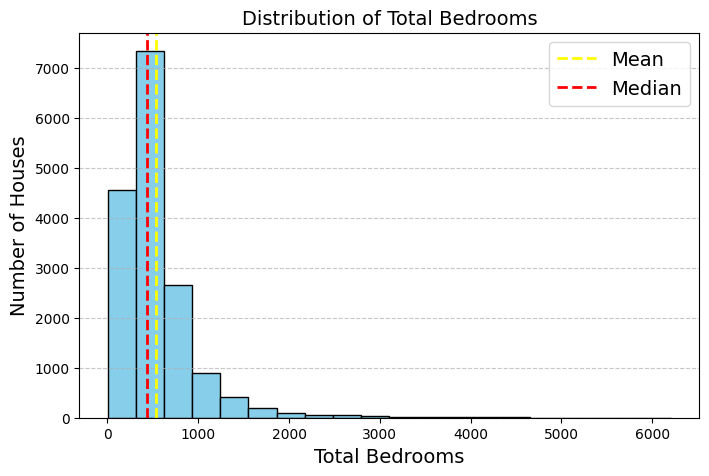

In [51]:
# total bedrooms 
plt.figure(figsize=(8, 5))
plt.hist(housing["total_bedrooms"], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Bedrooms')
plt.xlabel('Total Bedrooms')
plt.ylabel('Number of Houses')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(housing["total_bedrooms"].mean(), color='yellow', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(housing["total_bedrooms"].median(), color='red', linestyle='dashed', linewidth=2, label='Median')
plt.legend()
plt.show()

**Insight**: The data is highly represented with median and mean, so we can simply fill the missing value using the median value of the attribute

In [67]:
# Fill the missing values in housing data using sklearn SimpleImputer with median strategy

from sklearn.impute import SimpleImputer

# Select only numerical columns
housing_num = housing.select_dtypes(include=[np.number])

# Create the imputer with median strategy
imputer = SimpleImputer(strategy="median")

# Fit the imputer and transform the data
X = imputer.fit_transform(housing_num)

housing_num_imputed = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

# Copy imputed values back to the original housing dataframe
housing[housing_num.columns] = housing_num_imputed



In [68]:
# check any missing value
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_house_value    0
ocean_proximity       0
dtype: int64